In [1]:
import torch
from torchcfm.conditional_flow_matching import ExactOptimalTransportConditionalFlowMatcher
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

# project utilities (data loading, training loops, plotting, etc.)
from src.data_utils import *
from src.train_utils import *


# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple GPU via MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Hyperparameters
sigma = 0.1
num_epochs = 100 
num_epochs_marginal = 1000
log_interval = 25

# Flow Matching setup
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
# time discretization for NeuralODE integration
t_span = torch.linspace(0, 1, 100).to(device)

Using Apple GPU via MPS


In [2]:
# Load lupus patient dataset (IID split)
X_src_train_lupus_iid, X_src_test_lupus_iid, \
X_tgt_train_lupus_iid, X_tgt_test_lupus_iid, \
marginal_ctrl_lupus_iid_train, marginal_tgt_lupus_iid_train, \
marginal_ctrl_lupus_iid_test, marginal_tgt_lupus_iid_test, \
umap_src_lupus_iid, umap_tgt_lupus_iid, umap_model_lupus_iid, \
genes_lupus_iid = load_and_split_data(
    folder_path= "scrna-lupuspatients/kang-hvg.h5ad",
    split = "iid",                                                  # IID = random train/test split
    condition="condition",                                          # column in AnnData.obs
    control = "ctrl",                                               # value for control cells
    target = "stim",                                                # value for stimulated cells
    test_size=0.3                                                   # 70% train / 30% test
    )

#checks: shapes must align for pairing
assert(X_src_train_lupus_iid.shape == X_tgt_train_lupus_iid.shape)
assert(X_src_test_lupus_iid.shape == X_tgt_test_lupus_iid.shape)
assert(marginal_ctrl_lupus_iid_train.shape == marginal_tgt_lupus_iid_train.shape)
assert(marginal_ctrl_lupus_iid_test.shape == marginal_tgt_lupus_iid_test.shape)
assert(umap_src_lupus_iid.shape == umap_tgt_lupus_iid.shape)

# Initialize models + optimizers for training
# - model_lupus_iid: full gene expression model
# - model_marginal_lupus_iid: marginal-gene model
model_lupus_iid, model_marginal_lupus_iid, \
optimizer_lupus_iid, optimizer_marginal_lupus_iid= train_on_dataset(
    X_src_train_lupus_iid, 
    marginal_ctrl_lupus_iid_train,
    device=device, 
    )

/opt/anaconda3/envs/anaconda_environment/lib/python3.9/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/opt/anaconda3/envs/anaconda_environment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/anaconda_environment/lib/python3.9/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Epoch 25 completed - Avg loss: 0.5730 | Time: 67.84s


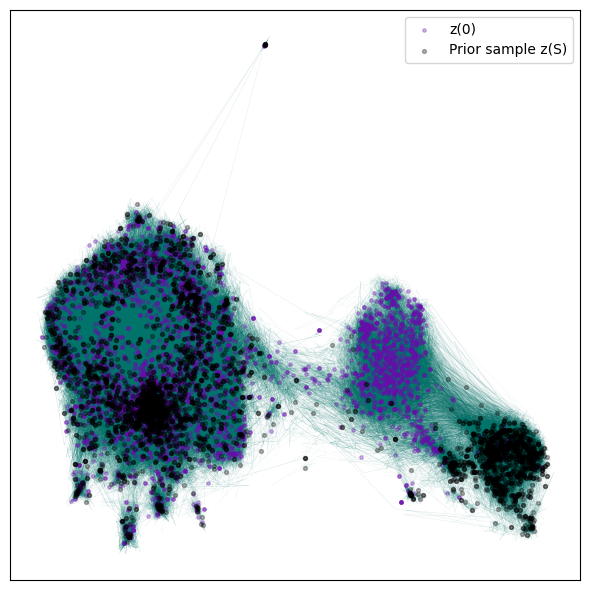

Epoch 50 completed - Avg loss: 0.5621 | Time: 372.34s


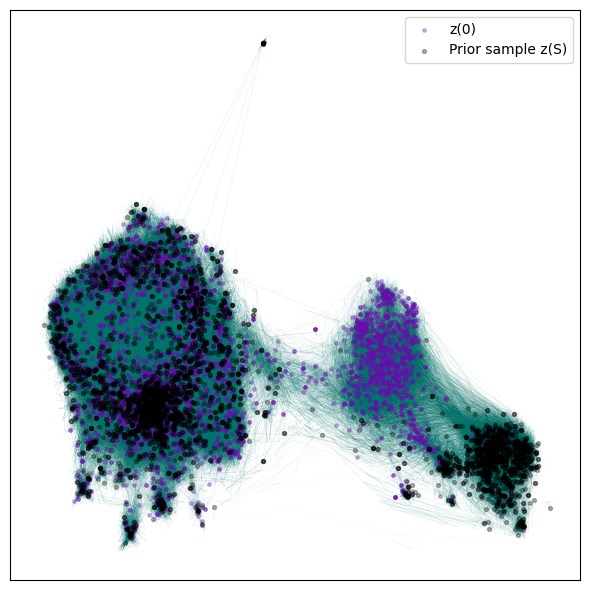

Epoch 75 completed - Avg loss: 0.5581 | Time: 343.61s


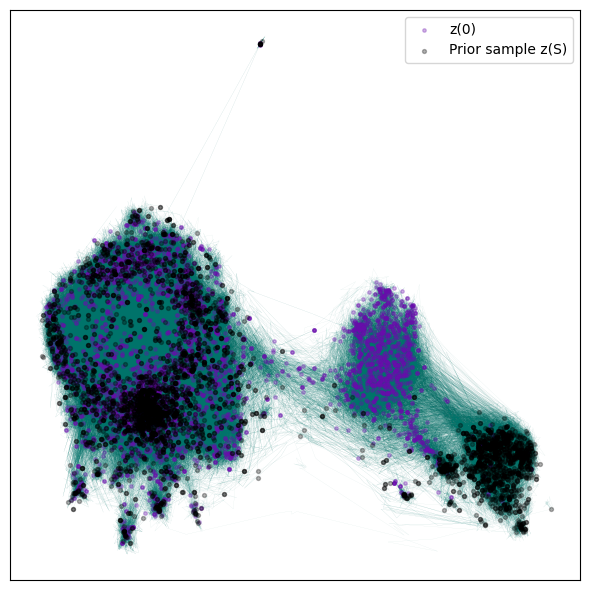

Epoch 100 completed - Avg loss: 0.5489 | Time: 387.79s


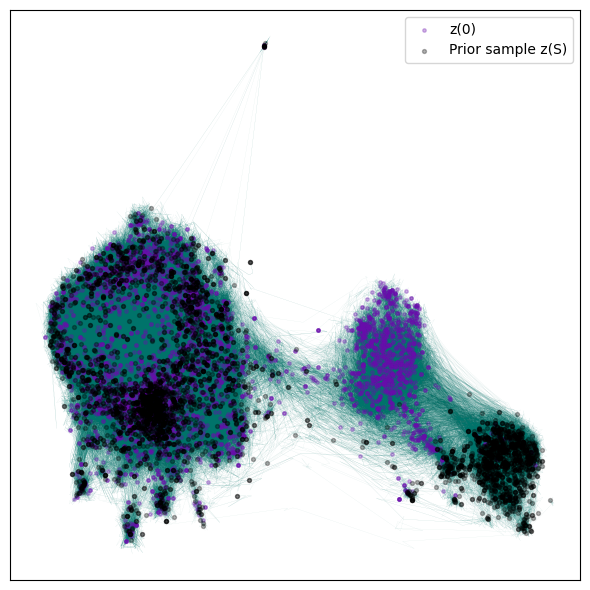

In [3]:
# Wrap training tensors into a paired dataset + dataloader
# Each item = (x0, x1) pair: source cell (ctrl), target cell (stim)
dataset_lupus_iid = PairedCellData(X_src_train_lupus_iid, X_tgt_train_lupus_iid)
dataloader_lupus_iid = DataLoader(dataset_lupus_iid, batch_size=2000, shuffle=True)

# Train full gene expression model on IID split
train_model(
    model_lupus_iid,                        # full model for IID experiment
    num_epochs,                             # training epochs
    dataloader_lupus_iid,                   # paired source-target batches
    FM,                                     # flow matcher (Exact OT-CFM)
    optimizer_lupus_iid,                    # optimizer for full model IID
    device,                                 # CPU/GPU/MPS
    log_interval,                           # logging + plotting frequency
    t_span,                                 # time grid for NeuralODE integration
    X_src_test_lupus_iid,                   # held-out test source cells         
    "lupus_iid",                            # experiment name (used in results/ folder)
    umap_model_lupus_iid,                   # pre-fit UMAP model for visualization
    umap_src_lupus_iid,                     # 2D UMAP coords of test source
    umap_tgt_lupus_iid,                     # 2D UMAP coords of test target
    )

In [ ]:
# Train marginal-gene model on IID split
train_for_marginals(
    model_marginal_lupus_iid,           # marginal model (marker genes only)
    num_epochs_marginal,                # more epochs since marginals are low-dim
    FM,                                 # flow matcher (Exact OT-CFM)
    optimizer_marginal_lupus_iid,       # optimizer for marginal model
    device,                             # CPU/GPU/MPS
    log_interval,                       # logging frequency
    t_span,                             # time grid for NeuralODE integration
    "lupus_iid",                        # experiment name (results saved under results/lupus_iid)
    genes_lupus_iid,                    # list of marker genes
    marginal_ctrl_lupus_iid_train,      # control marginals for training
    marginal_tgt_lupus_iid_train,       # treated marginals for training 
    marginal_ctrl_lupus_iid_test,       # control marginals for testing
    marginal_tgt_lupus_iid_test         # treated marginals for testing
    )

Epoch 25 completed - Avg loss: 0.3899 | Time: 281.87s
Epoch 50 completed - Avg loss: 0.3075 | Time: 776.51s
Epoch 75 completed - Avg loss: 0.2601 | Time: 310.74s
Epoch 100 completed - Avg loss: 0.2289 | Time: 300.49s
Epoch 125 completed - Avg loss: 0.2066 | Time: 2279.07s
Epoch 150 completed - Avg loss: 0.1896 | Time: 280.24s
Epoch 175 completed - Avg loss: 0.1765 | Time: 267.24s
Epoch 200 completed - Avg loss: 0.1654 | Time: 270.61s
Epoch 225 completed - Avg loss: 0.1571 | Time: 705.86s
Epoch 250 completed - Avg loss: 0.1496 | Time: 269.87s
Epoch 275 completed - Avg loss: 0.1434 | Time: 269.42s
Epoch 300 completed - Avg loss: 0.1380 | Time: 443.22s
Epoch 325 completed - Avg loss: 0.1335 | Time: 268.96s
Epoch 350 completed - Avg loss: 0.1295 | Time: 287.93s
Epoch 375 completed - Avg loss: 0.1262 | Time: 288.38s
Epoch 400 completed - Avg loss: 0.1231 | Time: 267.85s
Epoch 425 completed - Avg loss: 0.1202 | Time: 261.91s
Epoch 450 completed - Avg loss: 0.1178 | Time: 267.26s
Epoch 475 co

In [ ]:
# Load lupus patient dataset (OOD split)
X_src_train_lupus_ood, X_src_test_lupus_ood, \
X_tgt_train_lupus_ood, X_tgt_test_lupus_ood, \
marginal_ctrl_lupus_ood_train, marginal_tgt_lupus_ood_train, \
marginal_ctrl_lupus_ood_test, marginal_tgt_lupus_ood_test, \
umap_src_lupus_ood, umap_tgt_lupus_ood, umap_model_lupus_ood, \
genes_lupus_ood = load_and_split_data(
    folder_path= "scrna-lupuspatients-dataset/kang-hvg.h5ad",
    split = "ood",                                                      # OOD split (exclude patients)
    condition="condition",                                              # AnnData.obs column for condition
    control = "ctrl",                                                   # control label
    target = "stim",                                                    # treated label
    exclude_cols="sample_id",                                           # column to exclude by (patients)
    exclude_vals= [101, 107, 1015],                                     # held-out patient IDs
    test_size=0.3                                                       # fraction for test split
    )

#checks: shapes must align for pairing
assert(X_src_train_lupus_ood.shape == X_tgt_train_lupus_ood.shape)
assert(X_src_test_lupus_ood.shape == X_tgt_test_lupus_ood.shape)
assert(marginal_ctrl_lupus_ood_train.shape == marginal_tgt_lupus_ood_train.shape)
assert(marginal_ctrl_lupus_ood_test.shape == marginal_tgt_lupus_ood_test.shape)
assert(umap_src_lupus_ood.shape == umap_tgt_lupus_ood.shape)

# Initialize models + optimizers for OOD training
# - model_lupus_ood: full gene expression model
# - model_marginal_lupus_ood: marginal-gene model
model_lupus_ood, model_marginal_lupus_ood, optimizer_lupus_ood, optimizer_marginal_lupus_ood= train_on_dataset(
    X_src_train_lupus_ood, 
    marginal_ctrl_lupus_ood_train,
    device=device, 
    )

/opt/anaconda3/envs/ot-cfm/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Epoch 25 completed - Avg loss: 0.6292 | Time: 89.24s


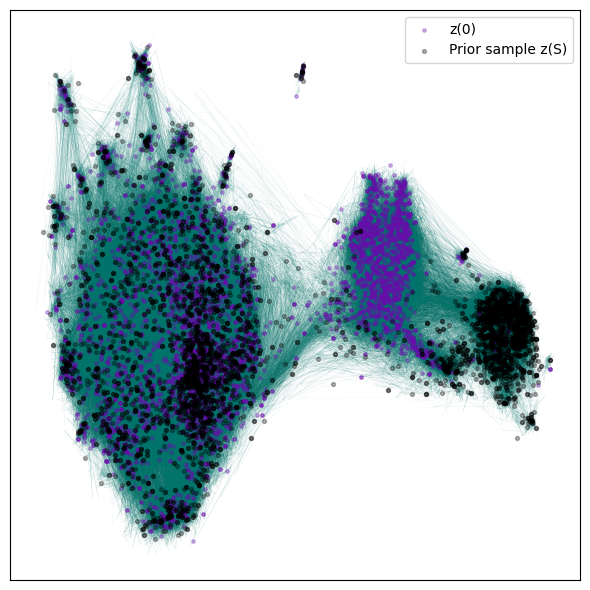

Epoch 50 completed - Avg loss: 0.6193 | Time: 435.76s


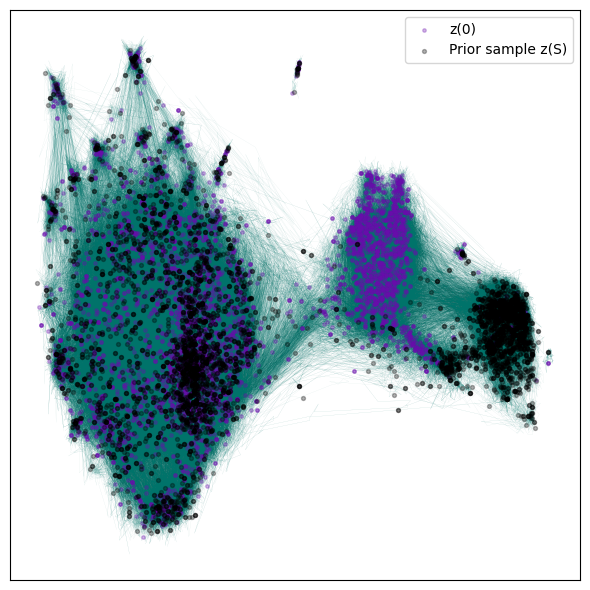

Epoch 75 completed - Avg loss: 0.6183 | Time: 390.72s


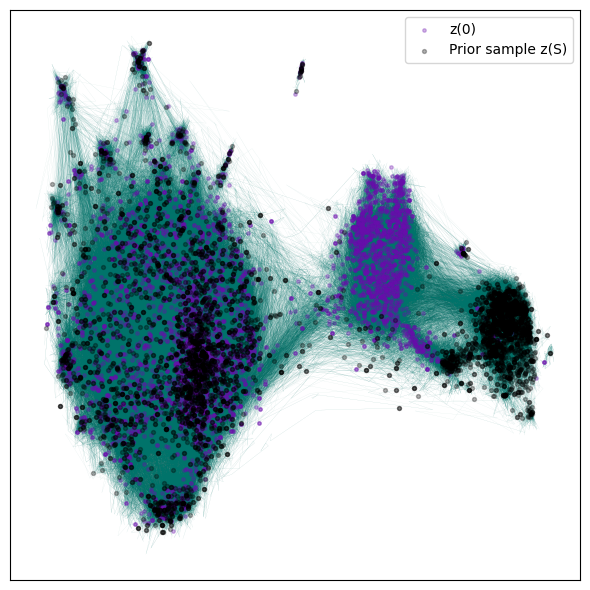

Epoch 100 completed - Avg loss: 0.6054 | Time: 377.87s


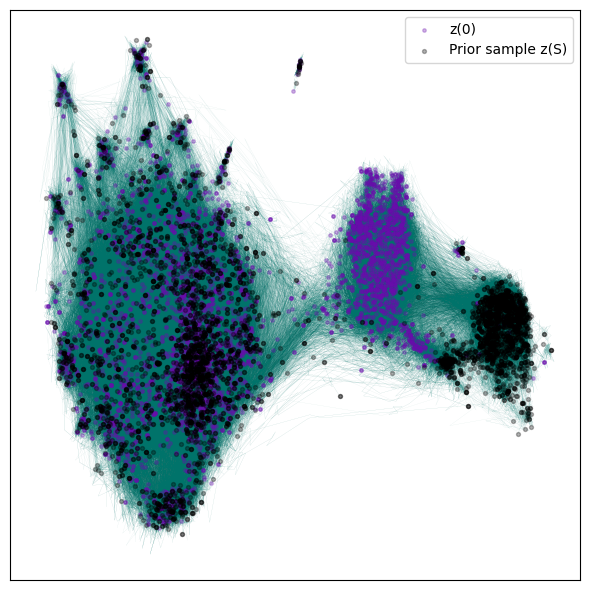

In [ ]:
# Wrap OOD split into a paired dataset + dataloader
# Each item = (x0, x1) pair: source cell (ctrl), target cell (stim)
dataset_lupus_ood = PairedCellData(X_src_train_lupus_ood, X_tgt_train_lupus_ood)
dataloader_lupus_ood = DataLoader(dataset_lupus_ood, batch_size=2000, shuffle=True)

# Train full gene expression model on OOD split
# - trains on source/target pairs from seen patients
# - evaluates generalization on held-out patients
train_model(
    model_lupus_ood,                # full model for OOD experiment
    num_epochs,                     # training epochs
    dataloader_lupus_ood,           # paired source-target dataloader
    FM,                             # flow matcher (Exact OT-CFM)
    optimizer_lupus_ood,            # optimizer for full OOD model
    device,                         # CPU/GPU/MPS
    log_interval,                   # logging + plotting frequency
    t_span,                         # time grid for NeuralODE integration
    X_src_test_lupus_ood,           # held-out test source cells  
    "lupus_ood",                    # experiment name (used in results/ folder)
    umap_model_lupus_ood,           # pre-fit UMAP model for visualization 
    umap_src_lupus_ood,             # 2D UMAP coords of test source
    umap_tgt_lupus_ood,             # 2D UMAP coords of test target
    )

In [ ]:
# Train marginal-gene model on IID split
train_for_marginals(
    model_marginal_lupus_ood,               # marginal model (marker genes only)
    num_epochs_marginal,                    # more epochs since marginals are low-dim
    FM,                                     # flow matcher (Exact OT-CFM)
    optimizer_marginal_lupus_ood,           # optimizer for marginal model
    device,                                 # CPU/GPU/MPS
    log_interval,                           # logging frequency
    t_span,                                 # time grid for NeuralODE integration
    "lupus_ood",                            # experiment name (results saved under results/lupus_ood)
    genes_lupus_ood,                        # list of marker genes
    marginal_ctrl_lupus_ood_train,          # control marginals for training
    marginal_tgt_lupus_ood_train,           # treated marginals for training 
    marginal_ctrl_lupus_ood_test,           # control marginals for testing
    marginal_tgt_lupus_ood_test             # treated marginals for testing
    )

Epoch 25 completed - Avg loss: 0.3395 | Time: 247.46s
Epoch 50 completed - Avg loss: 0.2611 | Time: 5101.78s
Epoch 75 completed - Avg loss: 0.2211 | Time: 383.70s
Epoch 100 completed - Avg loss: 0.1981 | Time: 247.24s
Epoch 125 completed - Avg loss: 0.1815 | Time: 241.79s
Epoch 150 completed - Avg loss: 0.1703 | Time: 249.52s
Epoch 175 completed - Avg loss: 0.1598 | Time: 242.30s
Epoch 200 completed - Avg loss: 0.1524 | Time: 244.26s
Epoch 225 completed - Avg loss: 0.1453 | Time: 252.47s
Epoch 250 completed - Avg loss: 0.1429 | Time: 252.64s
Epoch 275 completed - Avg loss: 0.1390 | Time: 246.22s
Epoch 300 completed - Avg loss: 0.1343 | Time: 233.48s
Epoch 325 completed - Avg loss: 0.1302 | Time: 300.58s
Epoch 350 completed - Avg loss: 0.1263 | Time: 236.77s
Epoch 375 completed - Avg loss: 0.1228 | Time: 248.40s
Epoch 400 completed - Avg loss: 0.1197 | Time: 243.81s
Epoch 425 completed - Avg loss: 0.1175 | Time: 249.37s
Epoch 450 completed - Avg loss: 0.1151 | Time: 258.44s
Epoch 475 co